In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import matplotlib
import re as re
import sqlite3

In [2]:
def read_all_tables(connection):
    files_dict = {}
    db_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", connection)
    for table in db_tables['name']:
        files_dict[table] = read_table(table, connection)
    return files_dict
def read_table(table_name, connection):
     return pd.read_sql_query("SELECT * from {}".format(table_name), connection)
    
conn = sqlite3.connect('../datascience-stackexchange.db')
files_df = read_all_tables(conn)

In [3]:
def top_users(files, sourceDF):
    #top users for posting or commenting
    base_count = files[sourceDF]['UserId'].value_counts().to_frame()
    base_count = base_count.rename(columns={'UserId':'Count'})
    base_count['UserId'] = base_count.index
    base_count['UserId'] = base_count['UserId'].replace('', np.nan)
    base_count.dropna(subset=['UserId'], inplace=True)
    base_count = base_count.reset_index(drop=True)
    files['Users_2'] = files['Users'].rename(columns={'Id': 'UserId'})
    df_merge_col = pd.merge(base_count, files['Users_2'], on='UserId')
    
    return df_merge_col

def top_100_location(files, sourceDF):
    df_merge_col = top_users(files, sourceDF)

    #count number of location
    location_count = df_merge_col['Location'].value_counts().to_frame()
    location_count =  location_count.rename(columns={'Location':'Count'})
    location_count['Location'] = location_count.index
    location_count = location_count.reset_index(drop=True)
    location_count


    location_count['Location'] = split_impl(location_count)
    location_count['Location'] = location_count['Location'].str[-1]

    #cleaning of spaces
    location_count['Location'] = location_count['Location'].str.strip()
    
    #top 100 users
    top_100 = location_count[:100]

    #get the number of unique location 
    top_100_country = top_100['Location'].value_counts().to_frame()
    top_100_country = top_100_country.rename(columns={'Location':'Count'})
    top_100_country['Location'] = top_100_country.index


    combineSimilarCountries(top_100_country, 'United States', 'USA')
    combineSimilarCountries(top_100_country, 'United Kingdom', 'UK')
    combineSimilarCountries(top_100_country, 'Canada', 'CA')

    top_100_country = top_100_country.sort_values(by=['Count'], ascending = False)
    top_100_country = top_100_country.reset_index(drop=True)
    return top_100_country

def split_impl(df):
    x = df['Location'].str.split(',')
    return (x)

def combineSimilarCountries (df, c1, c2):
    #c1 will be retained
    sum_ = df.loc[df['Location'].isin([c1,c2])]['Count'].sum()
    df.drop(df.loc[df['Location'] == c2].index, inplace=True)
    df.loc[df['Location'] == c1, ['Count']] = sum_
    
def bar_graph (df):
    my_plot = df.plot.bar(x='Location', y = 'Count', figsize = (12,4))
    my_plot = plt.xticks(rotation=90)


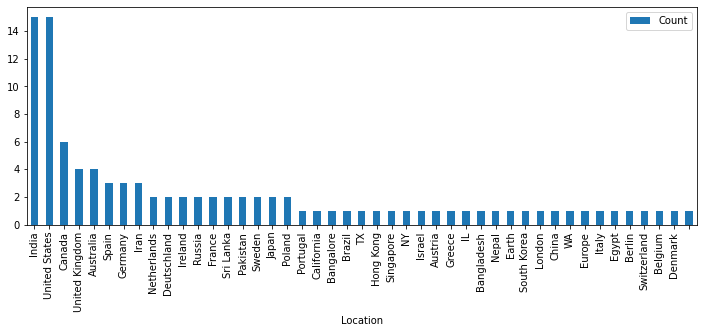

In [4]:
top_100_country_by_post_freq = top_100_location(files_df, 'PostHistory')
bar_graph(top_100_country_by_post_freq)

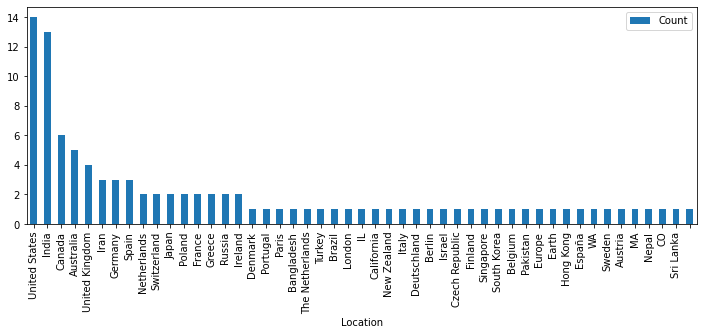

In [5]:
top_100_country_by_comments_freq = top_100_location(files_df, 'Comments')
bar_graph(top_100_country_by_comments_freq)

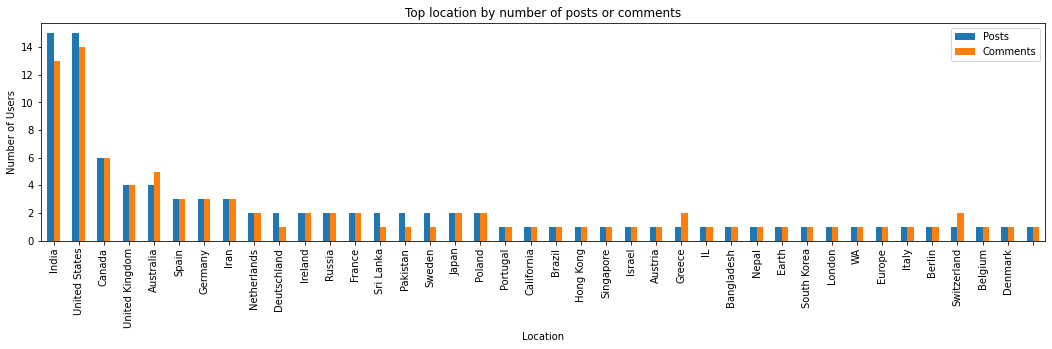

In [6]:
top_100_by_location = top_100_country_by_post_freq.merge(top_100_country_by_comments_freq ,on='Location')
top_100_by_location = top_100_by_location.set_index('Location')
top_100_by_location = top_100_by_location.rename(columns={'Count_x':'Posts', 'Count_y':'Comments'})
top_100_by_location.plot(kind="bar", figsize = (18,4))
plt.ylabel("Number of Users")
plt.title("Top location by number of posts or comments")
plt.savefig('../plots/top-location-by-number-of-posts-top-100', dpi=150, pad_inches = 0.3, bbox_inches='tight')
plt.show()